In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
    
# Load the dataset
df = pd.read_csv('animal_planet_cleaned.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nPopulation column values:")
print(df['Population'].unique())

Dataset shape: (23553, 22)

Column names: ['Name', 'Kingdom', 'Phylum', 'Subphylum', 'Class', 'Order', 'Suborder', 'Family', 'Genus', 'Species', 'Population size', 'Life span', 'Top speed', 'Weight', 'Height', 'Length', 'Attributes', 'Distribution', 'Habits', 'Diet', 'Mating_Habits', 'Population']

First few rows:
           Name   Kingdom    Phylum   Subphylum     Class         Order  \
0     Grey Wolf  Animalia  Chordata  Vertebrata  Mammalia     Carnivora   
1         Tiger  Animalia  Chordata  Vertebrata  Mammalia     Carnivora   
2    Brown Bear  Animalia  Chordata  Vertebrata  Mammalia     Carnivora   
3    Blue Whale  Animalia  Chordata  Vertebrata  Mammalia  Artiodactyla   
4  Killer Whale  Animalia  Chordata  Vertebrata  Mammalia  Artiodactyla   

     Suborder           Family         Genus                Species  ...  \
0  Caniformia          Canidae         Canis            Canis lupus  ...   
1  Feliformia          Felidae      Panthera        Panthera tigris  ...   
2  Ca

In [4]:
# Clean and prepare data
df_clean = df.dropna(subset=['Population'])

# Create conservation status mapping
conservation_mapping = {
    'Extinct (EX)': 'Extinct',
    'Extinct in the wild (EW)': 'Extinct in Wild',
    'Critically Endangered (CR)': 'Critically Endangered',
    'Endangered (EN)': 'Endangered',
    'Vulnerable (VU)': 'Vulnerable',
    'Near Threatened (NT)': 'Near Threatened',  
    'Least concern (LC)': 'Least Concern',
    'Data deficient (DD)': 'Data Deficient',
    'Not evaluated (NE)': 'Not Evaluated'
}

df_clean['Conservation_Status_Clean'] = df_clean['Population'].map(conservation_mapping)
df_clean['Conservation_Status_Clean'] = df_clean['Conservation_Status_Clean'].fillna('Unknown')

# Create conservation risk category
def assign_risk_category(status):
    if status in ['Critically Endangered', 'Endangered']:
        return 'High Risk'
    elif status in ['Vulnerable', 'Near Threatened']:
        return 'Medium Risk'
    elif status in ['Least Concern']:
        return 'Low Risk'
    else:
        return 'Unknown Risk'

df_clean['Risk_Category'] = df_clean['Conservation_Status_Clean'].apply(assign_risk_category)

print("Conservation Status Distribution:")
print(df_clean['Conservation_Status_Clean'].value_counts())
print("\nRisk Category Distribution:")
print(df_clean['Risk_Category'].value_counts())

Conservation Status Distribution:
Conservation_Status_Clean
Least Concern      14993
Vulnerable          1918
Data Deficient      1909
Endangered          1755
Near Threatened     1677
Unknown              986
Extinct              237
Not Evaluated         66
Extinct in Wild       12
Name: count, dtype: int64

Risk Category Distribution:
Risk_Category
Low Risk        14993
Medium Risk      3595
Unknown Risk     3210
High Risk        1755
Name: count, dtype: int64


In [5]:
# Feature engineering for numerical characteristics
df_features = df_clean.copy()

# Fill missing values
df_features['Population size'] = pd.to_numeric(df_features['Population size'], errors='coerce')
df_features['Life span'] = pd.to_numeric(df_features['Life span'], errors='coerce')
df_features['Top speed'] = pd.to_numeric(df_features['Top speed'], errors='coerce') 
df_features['Weight'] = pd.to_numeric(df_features['Weight'], errors='coerce')
df_features['Height'] = pd.to_numeric(df_features['Height'], errors='coerce')
df_features['Length'] = pd.to_numeric(df_features['Length'], errors='coerce')
 
# Fill numerical features with median
numerical_cols = ['Population size', 'Life span', 'Top speed', 'Weight', 'Height', 'Length']
for col in numerical_cols:
    df_features[col].fillna(df_features[col].median(), inplace=True)

# Class grouping
def categorize_class(class_name):
    if pd.isna(class_name):
        return 'Unknown'
    if 'Mammalia' in str(class_name):
        return 'Mammalia'
    else:
        return 'Other'

df_features['Class_Category'] = df_features['Class'].apply(categorize_class)

# Diet type encoding
def get_diet(diet_str):
    if pd.isna(diet_str):
        return 'Unknown'
    if 'Herbivore' in str(diet_str):
        return 'Herbivore'
    elif 'Carnivore' in str(diet_str):
        return 'Carnivore'
    else:
        return 'Omnivore'

df_features['Diet_Type'] = df_features['Diet'].apply(get_diet)

print("Class Distribution:")
print(df_features['Class_Category'].value_counts())
print("\nDiet Distribution:")
print(df_features['Diet_Type'].value_counts())

Class Distribution:
Class_Category
Other       17873
Mammalia     5680
Name: count, dtype: int64

Diet Distribution:
Diet_Type
Unknown      20943
Carnivore     1221
Herbivore      907
Omnivore       482
Name: count, dtype: int64


In [6]:
# Create size category based on weight
def categorize_size(weight):
    if weight < 10:
        return 'Tiny'
    elif weight < 100:
        return 'Small'
    elif weight < 1000:
        return 'Medium'
    else:
        return 'Large'

df_features['Size_Category'] = df_features['Weight'].apply(categorize_size)

# Population risk category
def population_risk(pop_size):
    if pop_size < 100:
        return 'Critical Population'
    elif pop_size < 10000:
        return 'Low Population'
    elif pop_size < 100000:
        return 'Moderate Population'
    else:
        return 'Stable Population'
    
df_features['Population_Risk'] = df_features['Population size'].apply(population_risk)

print("\nSize Category Distribution:")
print(df_features['Size_Category'].value_counts())
print("\nPopulation Risk Distribution:")
print(df_features['Population_Risk'].value_counts())


Size Category Distribution:
Size_Category
Tiny      23038
Small       320
Medium      153
Large        42
Name: count, dtype: int64

Population Risk Distribution:
Population_Risk
Stable Population      23229
Moderate Population      169
Low Population           148
Critical Population        7
Name: count, dtype: int64


In [7]:
# Create interactive Sankey diagram
import plotly.graph_objects as go
import plotly.express as px

# Prepare data for Sankey
sankey_df = df_features[['Class_Category', 'Diet_Type', 'Size_Category', 'Risk_Category']].copy()
sankey_df = sankey_df.dropna()

# Create flows for Sankey
# Class -> Diet
class_diet_flow = sankey_df.groupby(['Class_Category', 'Diet_Type']).size().reset_index(name='count')
# Diet -> Size
diet_size_flow = sankey_df.groupby(['Diet_Type', 'Size_Category']).size().reset_index(name='count')
# Size -> Risk
size_risk_flow = sankey_df.groupby(['Size_Category', 'Risk_Category']).size().reset_index(name='count')

# Combine all flows
all_nodes = (class_diet_flow['Class_Category'].tolist() + class_diet_flow['Diet_Type'].tolist() +
             diet_size_flow['Size_Category'].tolist() + size_risk_flow['Risk_Category'].tolist())
all_nodes = list(set(all_nodes))
all_nodes.sort()

# Create mapping
node_dict = {node: idx for idx, node in enumerate(all_nodes)}

# Prepare source, target, value
source = []
target = []
value = []
colors = []

# Add Class -> Diet
for _, row in class_diet_flow.iterrows():
    source.append(node_dict[row['Class_Category']])
    target.append(node_dict[row['Diet_Type']])
    value.append(row['count'])
    colors.append('rgba(31, 119, 180, 0.4)')

# Add Diet -> Size
for _, row in diet_size_flow.iterrows():
    source.append(node_dict[row['Diet_Type']])
    target.append(node_dict[row['Size_Category']])
    value.append(row['count'])
    colors.append('rgba(255, 127, 14, 0.4)')

# Add Size -> Risk
for _, row in size_risk_flow.iterrows():
    source.append(node_dict[row['Size_Category']])
    target.append(node_dict[row['Risk_Category']])
    value.append(row['count'])
    colors.append('rgba(44, 160, 44, 0.4)')

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
       node=dict(
           pad=15,
           thickness=20,
           line=dict(color='black', width=0.5),
           label=all_nodes,
            color=['rgba(31, 119, 180, 0.8)' if node in class_diet_flow['Class_Category'].values 
                   else
                   'rgba(255, 127, 14, 0.8)' if node in diet_size_flow['Diet_Type'].values 
                   else
                   'rgba(44, 160, 44, 0.8)' if node in size_risk_flow['Size_Category'].values 
                   else
                  'rgba(214, 39, 40, 0.8)'
                   for node in all_nodes]
       ),
    link=dict(
           source=source,
            target=target,
            value=value,
            color=colors
        )
    )])
    
fig.update_layout(
        title="Animal Conservation Status Flow: Class → Diet → Size → Risk Category",
        font=dict(size=12),
        height=800,
        hovermode='closest',
        margin=dict(b=20, l=20, r=160, t=40)
    )
    
fig.show()
    
print("\nSankey diagram created successfully!")


Sankey diagram created successfully!


In [8]:
# Prepare data for ML models\n",
from sklearn.preprocessing import LabelEncoder

# Select features for ML
ml_df = df_features[['Population size', 'Life span', 'Top speed', 'Weight', 'Height', 'Length',
                      'Class_Category', 'Diet_Type', 'Size_Category', 'Population_Risk', 'Risk_Category']].copy()
 
ml_df = ml_df.dropna()
# Encode categorical variables
le_dict = {}
categorical_cols = ['Class_Category', 'Diet_Type', 'Size_Category', 'Population_Risk']

for col in categorical_cols:
    le = LabelEncoder()
    ml_df[col + '_encoded'] = le.fit_transform(ml_df[col])
    le_dict[col] = le

# Prepare X and y
X = ml_df[['Population size', 'Life span', 'Top speed', 'Weight', 'Height', 'Length',
    'Class_Category_encoded', 'Diet_Type_encoded', 'Size_Category_encoded', 'Population_Risk_encoded']]

y = ml_df['Risk_Category']

# Encode target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")
print(f"\nTarget classes: {le_target.classes_}")
print(f"\nTarget distribution:")
print(pd.Series(y).value_counts())

Features shape: (23553, 10)
Target shape: (23553,)

Feature columns: ['Population size', 'Life span', 'Top speed', 'Weight', 'Height', 'Length', 'Class_Category_encoded', 'Diet_Type_encoded', 'Size_Category_encoded', 'Population_Risk_encoded']

Target classes: ['High Risk' 'Low Risk' 'Medium Risk' 'Unknown Risk']

Target distribution:
Risk_Category
Low Risk        14993
Medium Risk      3595
Unknown Risk     3210
High Risk        1755
Name: count, dtype: int64


In [9]:
# Train-test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train_scaled.shape}")
print(f"Test set size: {X_test_scaled.shape}")

Training set size: (18842, 10)
Test set size: (4711, 10)


In [10]:
# Train Random Forest Classifier\n",
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15)
rf_model.fit(X_train_scaled, y_train)
# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_train_rf = rf_model.predict(X_train_scaled)

# Accuracy
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_rf)

print("="*60)
print("RANDOM FOREST CLASSIFIER RESULTS")
print("="*60)
print(f"\nTraining Accuracy: {accuracy_train_rf:.4f}")
print(f"Test Accuracy: {accuracy_test_rf:.4f}")
print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_rf, target_names=le_target.classes_))

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_rf.head(10))

RANDOM FOREST CLASSIFIER RESULTS

Training Accuracy: 0.6721
Test Accuracy: 0.6340

Classification Report (Test Set):
              precision    recall  f1-score   support

   High Risk       0.32      0.02      0.05       324
    Low Risk       0.64      0.99      0.78      2973
 Medium Risk       0.39      0.02      0.04       737
Unknown Risk       0.50      0.02      0.03       677

    accuracy                           0.63      4711
   macro avg       0.46      0.26      0.22      4711
weighted avg       0.56      0.63      0.50      4711


Top 10 Most Important Features:
                   Feature  Importance
3                   Weight    0.262394
5                   Length    0.232565
1                Life span    0.135140
0          Population size    0.115747
7        Diet_Type_encoded    0.061827
2                Top speed    0.052519
6   Class_Category_encoded    0.051160
9  Population_Risk_encoded    0.036421
4                   Height    0.032928
8    Size_Category_encode

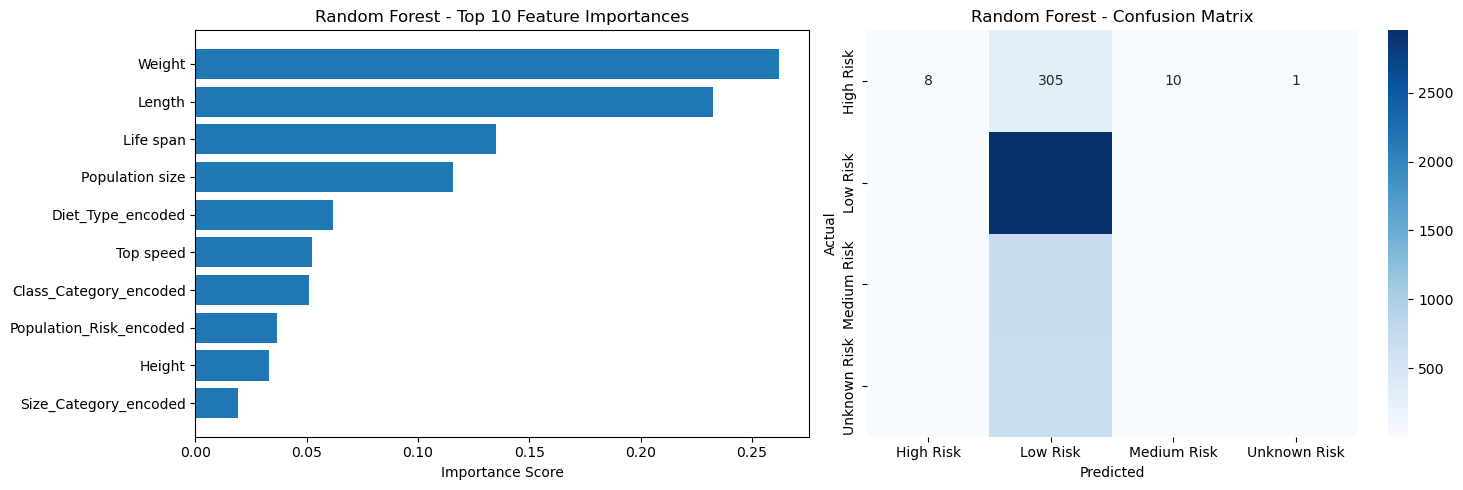

In [11]:
# Visualize Random Forest Feature Importance\n",
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Feature importance plot
axes[0].barh(feature_importance_rf['Feature'][:10], feature_importance_rf['Importance'][:10])
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Random Forest - Top 10 Feature Importances')
axes[0].invert_yaxis()

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_,
            yticklabels=le_target.classes_, ax=axes[1], cbar=True)
axes[1].set_title('Random Forest - Confusion Matrix')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

In [12]:
# Train Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_train_gb = gb_model.predict(X_train_scaled)


# Accuracy
accuracy_train_gb = accuracy_score(y_train, y_pred_train_gb)
accuracy_test_gb = accuracy_score(y_test, y_pred_gb)

print("="*60)
print("GRADIENT BOOSTING CLASSIFIER RESULTS")
print("="*60)
print(f"\nTraining Accuracy: {accuracy_train_gb:.4f}")
print(f"Test Accuracy: {accuracy_test_gb:.4f}")
print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_gb, target_names=le_target.classes_))

# Feature importance
feature_importance_gb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance_gb.head(10))

GRADIENT BOOSTING CLASSIFIER RESULTS

Training Accuracy: 0.6646
Test Accuracy: 0.6334

Classification Report (Test Set):
              precision    recall  f1-score   support

   High Risk       0.47      0.02      0.05       324
    Low Risk       0.64      0.99      0.78      2973
 Medium Risk       0.39      0.02      0.04       737
Unknown Risk       0.35      0.01      0.02       677

    accuracy                           0.63      4711
   macro avg       0.46      0.26      0.22      4711
weighted avg       0.55      0.63      0.50      4711


Top 10 Most Important Features:
                   Feature  Importance
3                   Weight    0.290501
0          Population size    0.197634
5                   Length    0.197001
1                Life span    0.104376
6   Class_Category_encoded    0.066466
2                Top speed    0.047965
7        Diet_Type_encoded    0.046221
4                   Height    0.034723
9  Population_Risk_encoded    0.011048
8    Size_Category_en

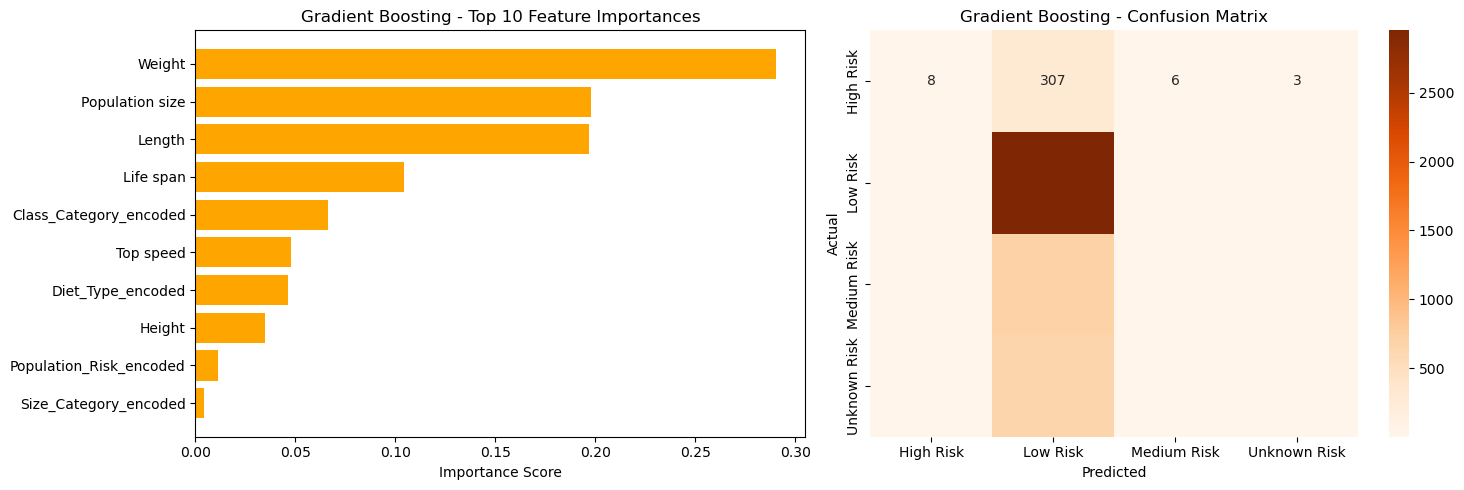

In [13]:
# Visualize Gradient Boosting Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Feature importance plot
axes[0].barh(feature_importance_gb['Feature'][:10], feature_importance_gb['Importance'][:10], color='orange')
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Gradient Boosting - Top 10 Feature Importances')
axes[0].invert_yaxis()

# Confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Oranges', xticklabels=le_target.classes_,
            yticklabels=le_target.classes_, ax=axes[1], cbar=True)
axes[1].set_title('Gradient Boosting - Confusion Matrix')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')
plt.tight_layout()
plt.show()

In [14]:
# Model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

# Add additional models
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr_model

svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)
models['SVM'] = svm_model

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
models['KNN'] = knn_model

# Evaluate all models
results = []
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Model': name, 'Test Accuracy': acc})

results_df = pd.DataFrame(results).sort_values('Test Accuracy', ascending=False)

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results_df.to_string(index=False))


MODEL COMPARISON
              Model  Test Accuracy
      Random Forest       0.634048
  Gradient Boosting       0.633411
Logistic Regression       0.633199
                SVM       0.631925
                KNN       0.626619


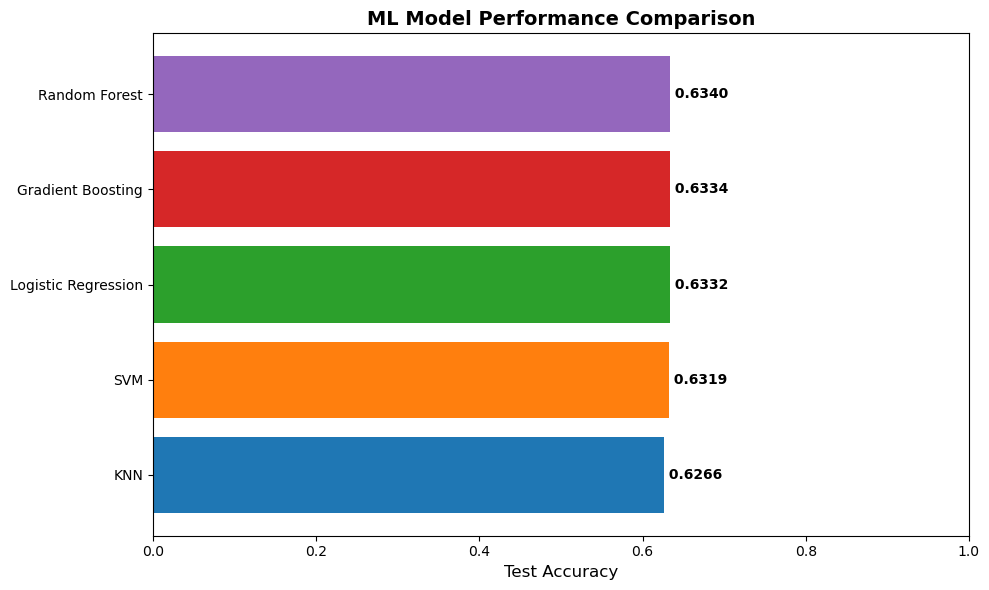

In [15]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(10, 6))
results_sorted = results_df.sort_values('Test Accuracy')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = ax.barh(results_sorted['Model'], results_sorted['Test Accuracy'], color=colors)
ax.set_xlabel('Test Accuracy', fontsize=12)
ax.set_title('ML Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1])

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f' {width:.4f}',
            ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [16]:
# Make predictions on new animals\n",
def predict_conservation_risk(pop_size, life_span, top_speed, weight, height, length,
                              class_cat, diet_type, size_cat, pop_risk, model='Random Forest'):
    """
    Predict conservation risk for an animal based on its characteristics.
    
    Parameters:
    - pop_size: Population size
    - life_span: Life span (years)
    - top_speed: Top speed (km/h)
    - weight: Weight (kg)
    - height: Height (m)
    - length: Length (m)
    - class_cat: Class category (e.g., 'Mammalia', 'Other')
    - diet_type: Diet type (e.g., 'Herbivore', 'Carnivore', 'Omnivore')
    - size_cat: Size category (e.g., 'Tiny', 'Small', 'Medium', 'Large')
    - pop_risk: Population risk (e.g., 'Critical Population', 'Low Population', etc.)
    - model: Which model to use ('Random Forest', 'Gradient Boosting', etc.)
    
    Returns:
    - Predicted risk category and confidence scores
    """
    
    # Encode categorical features
    class_encoded = le_dict['Class_Category'].transform([class_cat])[0]
    diet_encoded = le_dict['Diet_Type'].transform([diet_type])[0]
    size_encoded = le_dict['Size_Category'].transform([size_cat])[0]
    pop_risk_encoded = le_dict['Population_Risk'].transform([pop_risk])[0]
    
    # Create feature vector
    features = np.array([[pop_size, life_span, top_speed, weight, height, length,
                         class_encoded, diet_encoded, size_encoded, pop_risk_encoded]])
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Select model
    selected_model = models[model]
    
    # Make prediction
    prediction = selected_model.predict(features_scaled)[0]
    prediction_label = le_target.inverse_transform([prediction])[0]
    
    # Get prediction probabilities
    if hasattr(selected_model, 'predict_proba'):
        probabilities = selected_model.predict_proba(features_scaled)[0]
        confidence = max(probabilities)
        prob_dict = dict(zip(le_target.classes_, probabilities))
    else:
        confidence = None
        prob_dict = None
    
    return prediction_label, confidence, prob_dict
    
# Test predictions
print("\n" + "="*60)
print("SAMPLE PREDICTIONS ON NEW ANIMALS")
print("="*60)
    
# Example 1: Large herbivore with low population
pred1, conf1, probs1 = predict_conservation_risk(
        pop_size=5000, life_span=20, top_speed=60, weight=300, height=2, length=3,
        class_cat='Mammalia', diet_type='Herbivore', size_cat='Large',
        pop_risk='Low Population', model='Random Forest'
    )
print(f"\nExample 1: Large Herbivore with Low Population")
print(f"Predicted Risk: {pred1}")
print(f"Confidence: {conf1:.4f}")
print(f"Probabilities: {probs1}")
   
# Example 2: Small carnivore with critical population
pred2, conf2, probs2 = predict_conservation_risk(
        pop_size=50, life_span=15, top_speed=80, weight=50, height=0.5, length=1,
        class_cat='Mammalia', diet_type='Carnivore', size_cat='Small',
        pop_risk='Critical Population', model='Random Forest'
    )
print(f"\nExample 2: Small Carnivore with Critical Population")
print(f"Predicted Risk: {pred2}")
print(f"Confidence: {conf2:.4f}")
print(f"Probabilities: {probs2}")
   
   # Example 3: Tiny omnivore with stable population
pred3, conf3, probs3 = predict_conservation_risk(
        pop_size=500000, life_span=10, top_speed=30, weight=5, height=0.3, length=0.4,
        class_cat='Mammalia', diet_type='Omnivore', size_cat='Tiny',
        pop_risk='Stable Population', model='Random Forest'
    )
print(f"\nExample 3: Tiny Omnivore with Stable Population")
print(f"Predicted Risk: {pred3}")
print(f"Confidence: {conf3:.4f}")
print(f"Probabilities: {probs3}")


SAMPLE PREDICTIONS ON NEW ANIMALS

Example 1: Large Herbivore with Low Population
Predicted Risk: Medium Risk
Confidence: 0.5635
Probabilities: {'High Risk': 0.2711363636363636, 'Low Risk': 0.03537878787878788, 'Medium Risk': 0.5634848484848486, 'Unknown Risk': 0.13}

Example 2: Small Carnivore with Critical Population
Predicted Risk: High Risk
Confidence: 0.6300
Probabilities: {'High Risk': 0.63, 'Low Risk': 0.01, 'Medium Risk': 0.11, 'Unknown Risk': 0.25}

Example 3: Tiny Omnivore with Stable Population
Predicted Risk: Low Risk
Confidence: 0.6990
Probabilities: {'High Risk': 0.04189557226399332, 'Low Risk': 0.6990417710944027, 'Medium Risk': 0.20724227234753548, 'Unknown Risk': 0.0518203842940685}


In [17]:
# Create interactive prediction tool
print("\n" + "="*60)
print("INTERACTIVE PREDICTION TOOL REFERENCE")
print("="*60)
print("""
    Use the function below to predict conservation risk for any animal:
    
    predict_conservation_risk(
        pop_size=<population_size>,
        life_span=<years>,
        top_speed=<km/h>,
        weight=<kg>,
        height=<meters>,
        length=<meters>,
        class_cat='Mammalia' or 'Other',
        diet_type='Herbivore' or 'Carnivore' or 'Omnivore',
        size_cat='Tiny' or 'Small' or 'Medium' or 'Large',
        pop_risk='Critical Population' or 'Low Population' or 'Moderate Population' or 'Stable Population',
        model='Random Forest' or 'Gradient Boosting' or 'Logistic Regression' or 'SVM' or 'KNN'
    )
    
    Returns: (predicted_risk_category, confidence_score, probability_dictionary)
    """)


INTERACTIVE PREDICTION TOOL REFERENCE

    Use the function below to predict conservation risk for any animal:
    
    predict_conservation_risk(
        pop_size=<population_size>,
        life_span=<years>,
        top_speed=<km/h>,
        weight=<kg>,
        height=<meters>,
        length=<meters>,
        class_cat='Mammalia' or 'Other',
        diet_type='Herbivore' or 'Carnivore' or 'Omnivore',
        size_cat='Tiny' or 'Small' or 'Medium' or 'Large',
        pop_risk='Critical Population' or 'Low Population' or 'Moderate Population' or 'Stable Population',
        model='Random Forest' or 'Gradient Boosting' or 'Logistic Regression' or 'SVM' or 'KNN'
    )
    
    Returns: (predicted_risk_category, confidence_score, probability_dictionary)
    


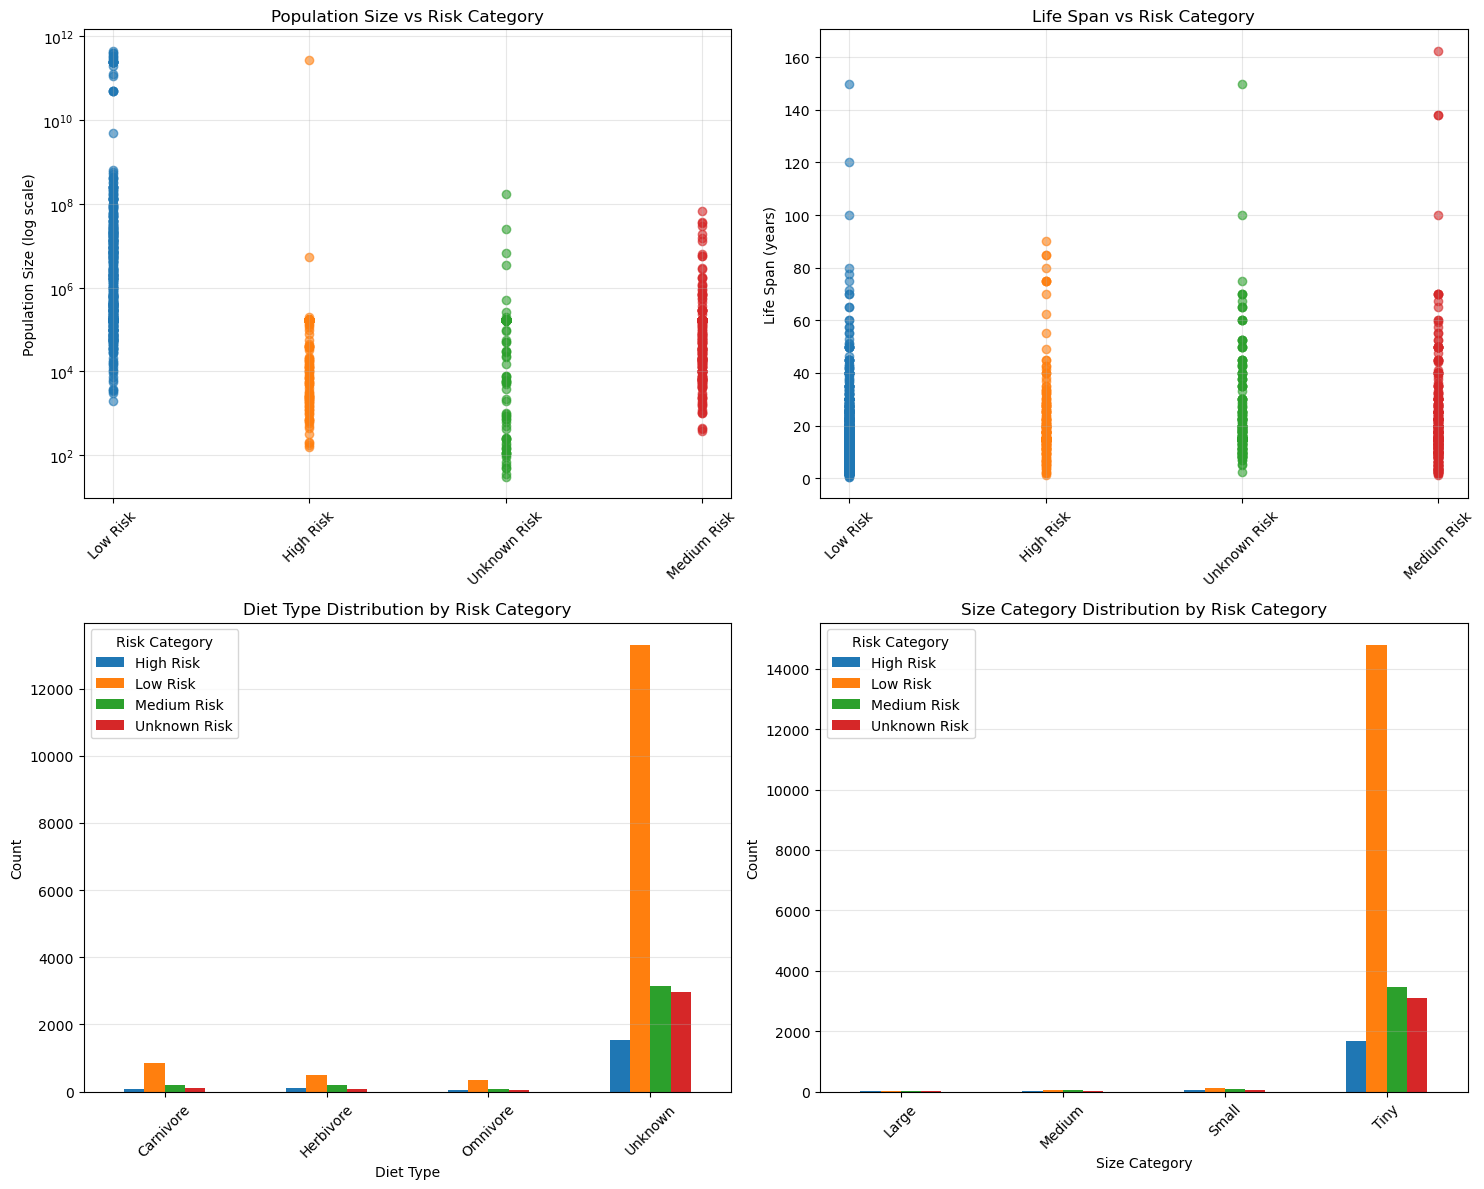

In [18]:
# Create a detailed analysis of risk factors
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Population size vs Risk category
for risk in ml_df['Risk_Category'].unique():
    data = ml_df[ml_df['Risk_Category'] == risk]['Population size']
    axes[0, 0].scatter([risk]*len(data), data, alpha=0.6, label=risk)
axes[0, 0].set_ylabel('Population Size (log scale)')
axes[0, 0].set_yscale('log')
axes[0, 0].set_title('Population Size vs Risk Category')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Life span vs Risk category
for risk in ml_df['Risk_Category'].unique():
    data = ml_df[ml_df['Risk_Category'] == risk]['Life span']
    axes[0, 1].scatter([risk]*len(data), data, alpha=0.6, label=risk)
axes[0, 1].set_ylabel('Life Span (years)')
axes[0, 1].set_title('Life Span vs Risk Category')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Diet type distribution by risk
diet_risk = pd.crosstab(ml_df['Diet_Type'], ml_df['Risk_Category'])
diet_risk.plot(kind='bar', ax=axes[1, 0], stacked=False)
axes[1, 0].set_title('Diet Type Distribution by Risk Category')
axes[1, 0].set_xlabel('Diet Type')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend(title='Risk Category')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Size category distribution by risk
size_risk = pd.crosstab(ml_df['Size_Category'], ml_df['Risk_Category'])
size_risk.plot(kind='bar', ax=axes[1, 1], stacked=False)
axes[1, 1].set_title('Size Category Distribution by Risk Category')
axes[1, 1].set_xlabel('Size Category')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(title='Risk Category')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

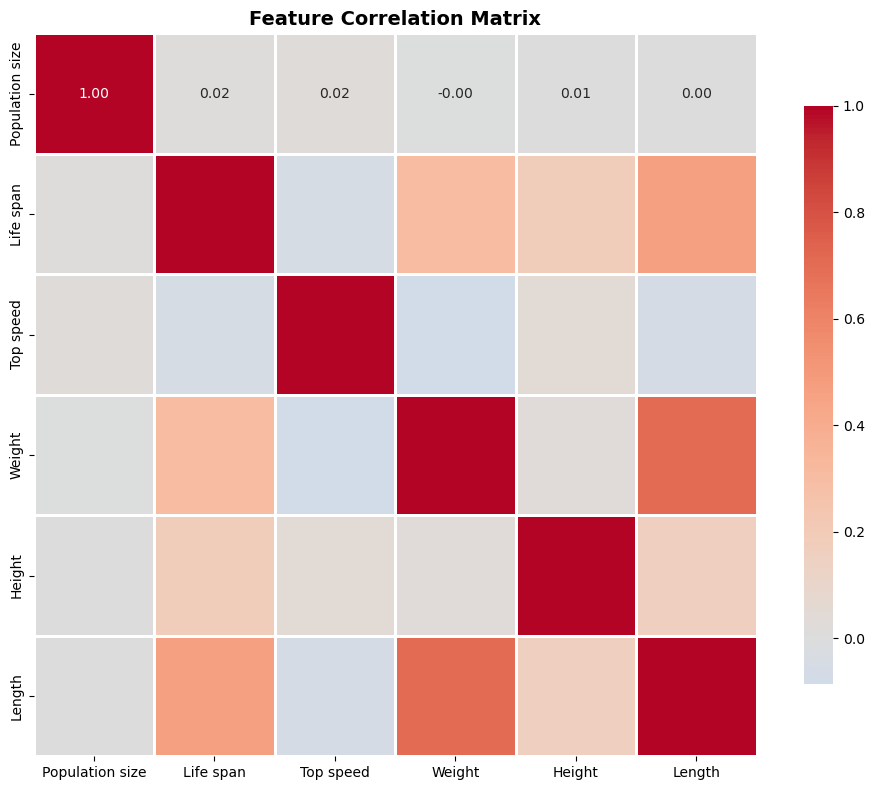


Correlation Matrix:
                 Population size  Life span  Top speed    Weight    Height  \
Population size         1.000000   0.015522   0.017570 -0.000647  0.011429   
Life span               0.015522   1.000000  -0.047814  0.308631  0.174934   
Top speed               0.017570  -0.047814   1.000000 -0.085888  0.042179   
Weight                 -0.000647   0.308631  -0.085888  1.000000  0.029035   
Height                  0.011429   0.174934   0.042179  0.029035  1.000000   
Length                  0.004022   0.467523  -0.055483  0.710510  0.159355   

                   Length  
Population size  0.004022  
Life span        0.467523  
Top speed       -0.055483  
Weight           0.710510  
Height           0.159355  
Length           1.000000  


In [19]:
# Feature correlation analysis
import seaborn as sns

# Select numerical features
corr_df = ml_df[['Population size', 'Life span', 'Top speed', 'Weight', 'Height', 'Length']].copy()

# Calculate correlation
correlation_matrix = corr_df.corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix:")
print(correlation_matrix)

In [21]:
# Model persistence - Save the trained models
import joblib
import pickle

# Save models
model_artifacts = {
    'rf_model': rf_model,
    'gb_model': gb_model,
    'lr_model': lr_model,
    'svm_model': svm_model,
    'knn_model': knn_model,
    'scaler': scaler,
    'le_target': le_target,
    'le_dict': le_dict
}

print("\nModel artifacts prepared for persistence.")
joblib.dump(model_artifacts, 'animal_conservation_models.pkl')
print("\nTo save models for later use, uncomment the joblib.dump line above.")
print("To load models: model_artifacts = joblib.load('animal_conservation_models.pkl')")


Model artifacts prepared for persistence.

To save models for later use, uncomment the joblib.dump line above.
To load models: model_artifacts = joblib.load('animal_conservation_models.pkl')


In [23]:
# Summary Report
print("\n" + "="*80)
print(" "*15 + "ANIMAL CONSERVATION RISK PREDICTION - SUMMARY REPORT")
print("="*80)
print(f"\n1. DATASET OVERVIEW:")
print(f"   - Total animals analyzed: {len(ml_df)}")
print(f"   - Risk categories: {len(le_target.classes_)} ({', '.join(le_target.classes_)})")
print(f"   - Features used: {len(X.columns)}")
print(f"\n2. RISK DISTRIBUTION:")
for risk, count in pd.Series(y).value_counts().items():
    pct = (count / len(y)) * 100
    print(f"   - {risk}: {count} animals ({pct:.1f}%)")
print(f"\n3. MODEL PERFORMANCE:")
print(f"   - Best Model: {results_df.iloc[0]['Model']} (Accuracy: {results_df.iloc[0]['Test Accuracy']:.4f})")
print(f"   - Training/Test split: 80/20")
print(f"   - Training samples: {len(X_train)}")
print(f"   - Testing samples: {len(X_test)}")

print(f"\n4. KEY FEATURES AFFECTING CONSERVATION RISK:")
top_features = feature_importance_rf.head(5)
for idx, (_, row) in enumerate(top_features.iterrows(), 1):
    print(f"   {idx}. {row['Feature']}: {row['Importance']:.4f}")
print(f"\n5. CATEGORICAL DISTRIBUTIONS:")
print(f"   - Class types: {', '.join(ml_df['Class_Category'].unique())}")
print(f"   - Diet types: {', '.join(ml_df['Diet_Type'].unique())}")
print(f"   - Size categories: {', '.join(ml_df['Size_Category'].unique())}")
print(f"   - Population risk levels: {', '.join(ml_df['Population_Risk'].unique())}")

print(f"\n6. INTERACTIVE FEATURES:")
print(f"   ✓ Sankey diagram showing Class → Diet → Size → Risk flow")
print(f"   ✓ Multiple ML models for predictions")
print(f"   ✓ Feature importance analysis")
print(f"   ✓ Confusion matrices and classification reports")
print(f"   ✓ Prediction function for new animals")

print("\n" + "="*80)
print("Ready for conservation risk predictions on new animals!")
print("="*80)


               ANIMAL CONSERVATION RISK PREDICTION - SUMMARY REPORT

1. DATASET OVERVIEW:
   - Total animals analyzed: 23553
   - Risk categories: 4 (High Risk, Low Risk, Medium Risk, Unknown Risk)
   - Features used: 10

2. RISK DISTRIBUTION:
   - Low Risk: 14993 animals (63.7%)
   - Medium Risk: 3595 animals (15.3%)
   - Unknown Risk: 3210 animals (13.6%)
   - High Risk: 1755 animals (7.5%)

3. MODEL PERFORMANCE:
   - Best Model: Random Forest (Accuracy: 0.6340)
   - Training/Test split: 80/20
   - Training samples: 18842
   - Testing samples: 4711

4. KEY FEATURES AFFECTING CONSERVATION RISK:
   1. Weight: 0.2624
   2. Length: 0.2326
   3. Life span: 0.1351
   4. Population size: 0.1157
   5. Diet_Type_encoded: 0.0618

5. CATEGORICAL DISTRIBUTIONS:
   - Class types: Mammalia, Other
   - Diet types: Carnivore, Omnivore, Herbivore, Unknown
   - Size categories: Small, Medium, Large, Tiny
   - Population risk levels: Stable Population, Low Population, Moderate Population, Critical Pop